In [9]:
# Cancer Research Paper Classification
# A comprehensive NLP pipeline for classifying cancer research papers

# Step 1: Import required libraries
# Standard library imports
import re
from collections import Counter

# Third-party imports
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Feature extraction and machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Transformers
import torch
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/alldata_1_for_kaggle.csv', encoding='ISO-8859-1')

Mounted at /content/drive


In [10]:
# Step 2: Load and prepare the data
# Set a random seed for reproducibility
RANDOM_SEED = 44

# Load the dataset
#df = pd.read_csv('/Users/nithyashreebr/UMASS/OneDrive - UMass Lowell/UMASS/Advance Machine Learning/project/research_papers.csv',
#                 encoding='ISO-8859-1')

# Select relevant columns
df = df.iloc[:, -2:]
df.columns = ["cancer_type", "research_paper"]

# Confirm sampling result
print("Subset shape:", df.shape)
print("Class distribution in subset:")
print(df['cancer_type'].value_counts())

Subset shape: (7570, 2)
Class distribution in subset:
cancer_type
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64


In [11]:
# Cleaning & removing stop words
data = df

# Download stopwords if not already
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.add('et')   # adding some paper specific stopwords
stop_words.add('al')
stop_words.add('aal')
stop_words.add('p')
stop_words.add('b')
stop_words.add('j')
stop_words.add('page')
stop_words.add('c')
stop_words.add('also')

# Define cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply cleaning
data['research_paper'] = data['research_paper'].apply(clean_text)

# Check
data[['cancer_type', 'research_paper']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,cancer_type,research_paper
0,Thyroid_Cancer,thyroid surgery children single institution os...
1,Thyroid_Cancer,adopted strategy used prior years based four e...
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis brin...
3,Thyroid_Cancer,solitary plasmacytoma sp skull uncommon clinic...
4,Thyroid_Cancer,study aimed investigate serum matrix metallopr...


In [12]:
# Step 4: Check the basic info
print("Shape of the dataset:", data.shape)
print("\nColumn names:", data.columns.tolist())
print("\nSample rows:")
display(data.head())

# Step 5: Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

Shape of the dataset: (7570, 2)

Column names: ['cancer_type', 'research_paper']

Sample rows:


,cancer_type,research_paper
0,Thyroid_Cancer,thyroid surgery children single institution os...
1,Thyroid_Cancer,adopted strategy used prior years based four e...
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis brin...
3,Thyroid_Cancer,solitary plasmacytoma sp skull uncommon clinic...
4,Thyroid_Cancer,study aimed investigate serum matrix metallopr...



Missing values:
cancer_type       0
research_paper    0
dtype: int64


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cancer_type     7570 non-null   object
 1   research_paper  7570 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB


**I.  Exploratory Data Analysis**

<ipython-input-14-56ecbdfaf8f8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='cancer_type', palette='viridis')


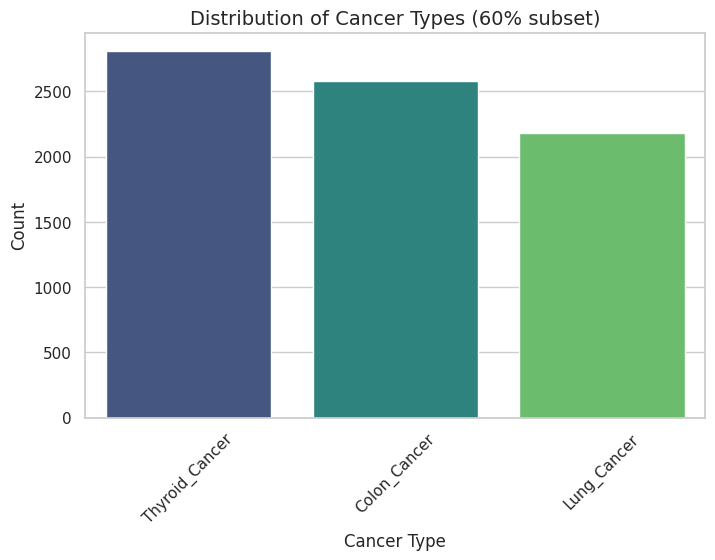

In [14]:
#Cancer Type Distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Plot class distribution
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='cancer_type', palette='viridis')
plt.title('Distribution of Cancer Types (60% subset)', fontsize=14)
plt.xlabel('Cancer Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


<ipython-input-15-afac0cd72f69>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='cancer_type', y='text_length', palette='magma', ci=None)
<ipython-input-15-afac0cd72f69>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='cancer_type', y='text_length', palette='magma', ci=None)


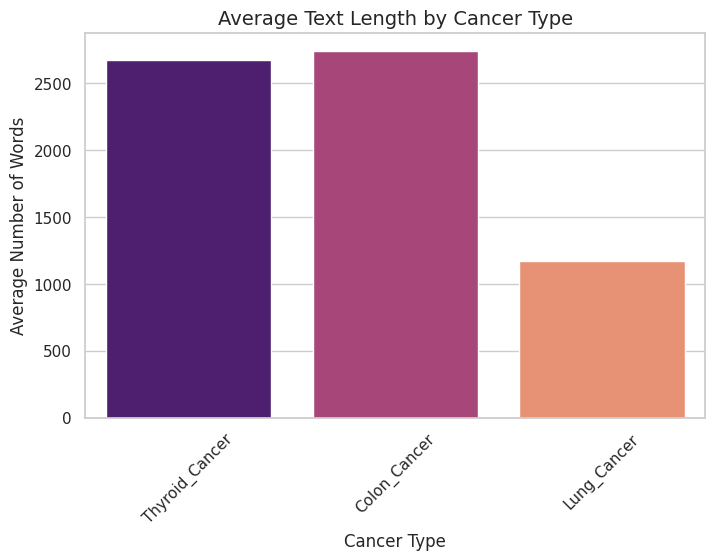

In [15]:
#abstract length analysis

# Create a new column for text length
data['text_length'] = data['research_paper'].apply(lambda x: len(x.split()))

# Plot average text length per cancer type
plt.figure(figsize=(8,5))
sns.barplot(data=data, x='cancer_type', y='text_length', palette='magma', ci=None)
plt.title('Average Text Length by Cancer Type', fontsize=14)
plt.xlabel('Cancer Type', fontsize=12)
plt.ylabel('Average Number of Words', fontsize=12)
plt.xticks(rotation=45)
plt.show()


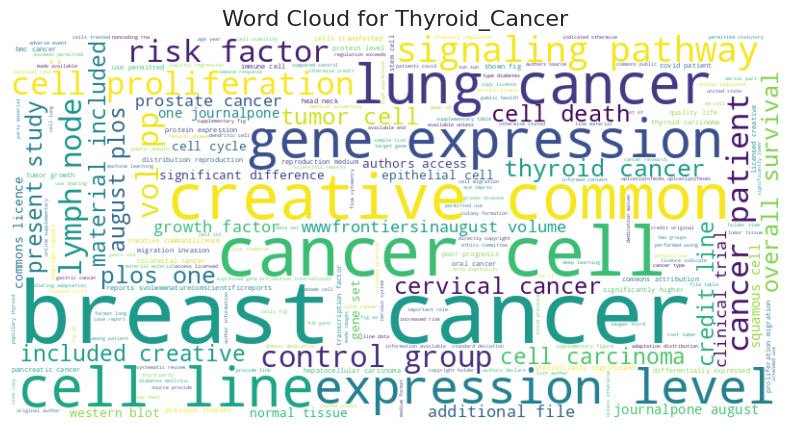

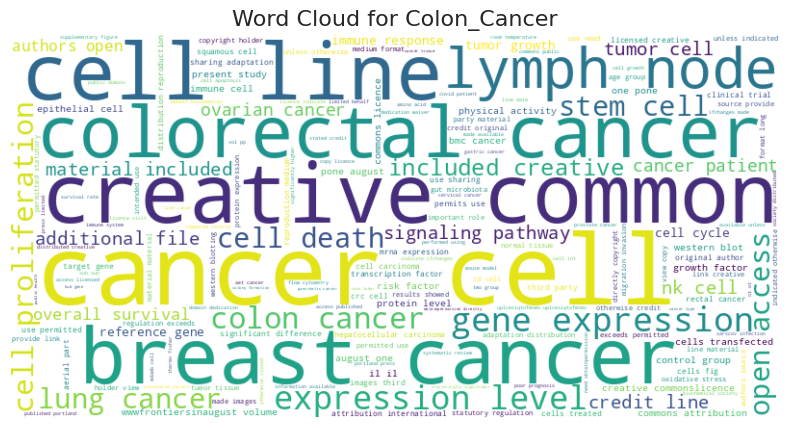

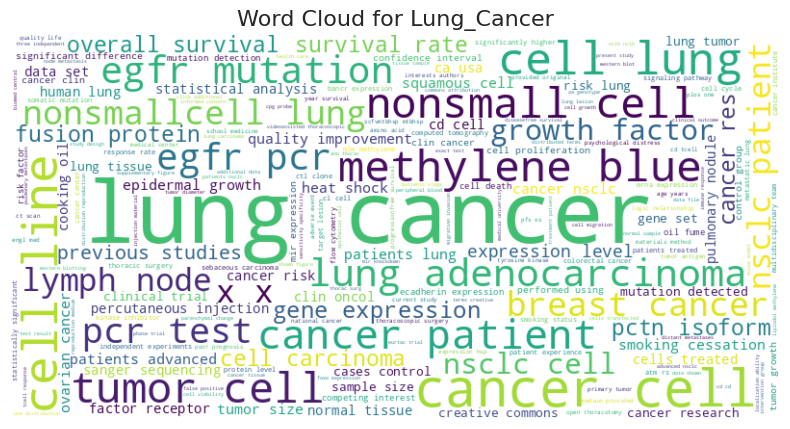

In [16]:
# Word Clouds per Cancer Type

from wordcloud import WordCloud

# Function to generate word cloud for a given label
def generate_wordcloud(label):
    text = " ".join(data[data['cancer_type'] == label]['research_paper'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {label}", fontsize=16)
    plt.show()

# Generate word clouds for each cancer type
for cancer_type in data['cancer_type'].unique():
    generate_wordcloud(cancer_type)


<ipython-input-17-abfbc6a13dc0>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_words_df, x='Frequency', y='Word', palette='cubehelix')


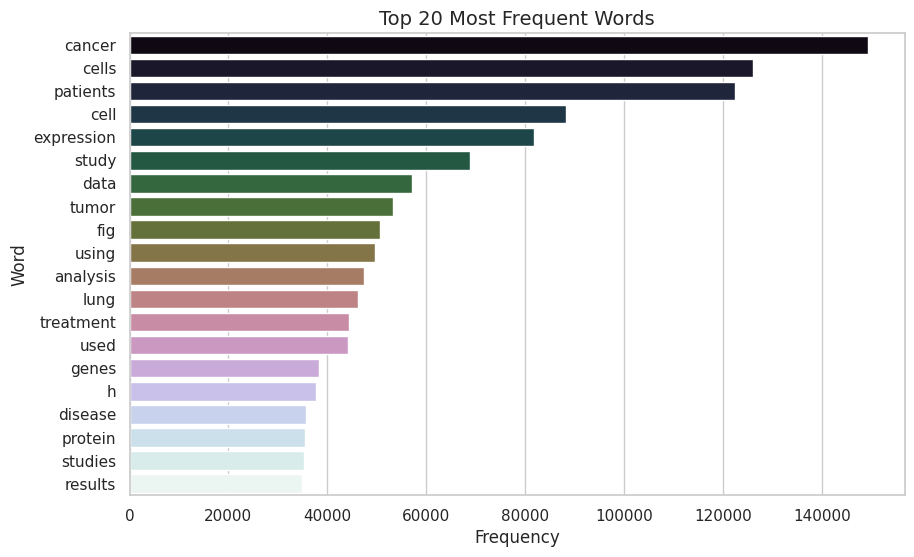

In [17]:
# Most Frequent Words Across All Cancer Types

from collections import Counter

# Tokenize all text
all_words = " ".join(data['research_paper']).split()

# Count the words
word_counts = Counter(all_words)

# Get top 20 most common words
common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=common_words_df, x='Frequency', y='Word', palette='cubehelix')
plt.title('Top 20 Most Frequent Words', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.show()


**II. Text Pre - Processing**

In [18]:
# Tokenization with sklearn: set to lower case and remove stop words
from sklearn.feature_extraction.text import CountVectorizer
raw_tf = CountVectorizer(lowercase=True, stop_words='english')
raw_tf_sparse = raw_tf.fit_transform(data.research_paper)
raw_tf_sparse

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7351999 stored elements and shape (7570, 177448)>

In [19]:
raw_tf_dictionary = raw_tf.get_feature_names_out()
print(raw_tf_dictionary)

['aa' 'aaa' 'aaaaa' ... 'zzand' 'zzhou' 'zzz']


In [20]:
raw_tfidf1 = TfidfTransformer()                     # Create the TF-IDF transformer
raw_tfidf1_sparse = raw_tfidf1.fit_transform(raw_tf_sparse)  # Transform the raw word counts

In [21]:
# Step 6: Data splitting for machine learning
# Define features and labels
X = raw_tfidf1_sparse
y = data['cancer_type']

# First split into Temporary (80%) and Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=44, stratify=y)

# Now split Temporary (80%) into Train (60%) and Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=44, stratify=y_temp)

# Confirm sizes
print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Train set: (4542, 177448)
Validation set: (1514, 177448)
Test set: (1514, 177448)


We are not encoding the models : Cancer_types; because sckit-Learn can handle these without encoding. We'll encode these when we use tensorflow and Deep Learning.

**I. Multinomial Naive Bayes Modeling**

Validation Accuracy: 0.9122

Validation Classification Report:
                 precision    recall  f1-score   support

  Colon_Cancer       0.90      0.84      0.87       516
   Lung_Cancer       1.00      0.99      0.99       436
Thyroid_Cancer       0.86      0.92      0.89       562

      accuracy                           0.91      1514
     macro avg       0.92      0.92      0.92      1514
  weighted avg       0.91      0.91      0.91      1514



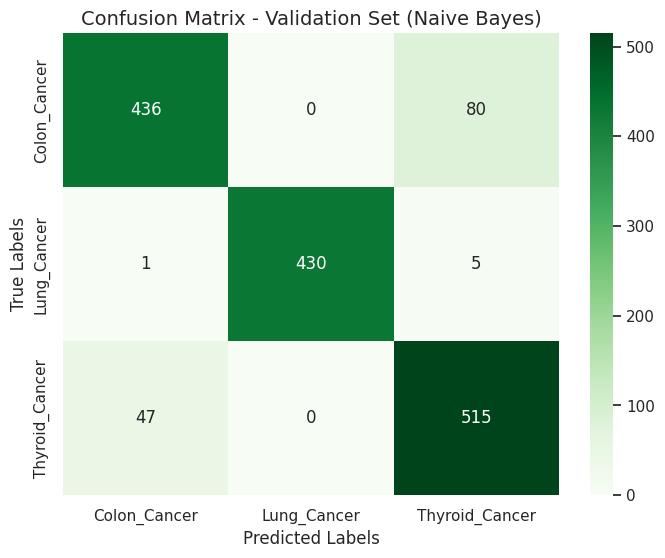

In [22]:
# Step 1: Train the model on TRAINING SET
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 2: Predict on VALIDATION SET
y_val_pred = nb_model.predict(X_val)

# Step 3: Evaluate on VALIDATION SET
print("Validation Accuracy:", round(accuracy_score(y_val, y_val_pred), 4))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix on Validation Set
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix - Validation Set (Naive Bayes)", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


As we can see the Naive Bayes model is performing all too well for the validation set and since we're happy with the results. We aren't making any modifications.
If the *validation set performance were to be poor*, we could have done one of the following things:

1. **Perform Data Quality checks to ensure data quality is good. (Garbage IN Garbage OUT)**

2. **Feature engineering improvements (using 2-grams instead of 1-grams or playing with max_features)**

3. **Hyper-parameter tuning (alpha (Laplace smoothing) of Naive bayes)**

4. **Data Augmentation (oversampling rare cancer types, etc.)**

**II. Logistic Regression with TF-IDF embeddings.**

Validation Accuracy (Logistic Regression): 0.9326

Validation Classification Report (Logistic Regression):
                 precision    recall  f1-score   support

  Colon_Cancer       0.90      0.90      0.90       516
   Lung_Cancer       1.00      1.00      1.00       436
Thyroid_Cancer       0.91      0.91      0.91       562

      accuracy                           0.93      1514
     macro avg       0.94      0.94      0.94      1514
  weighted avg       0.93      0.93      0.93      1514



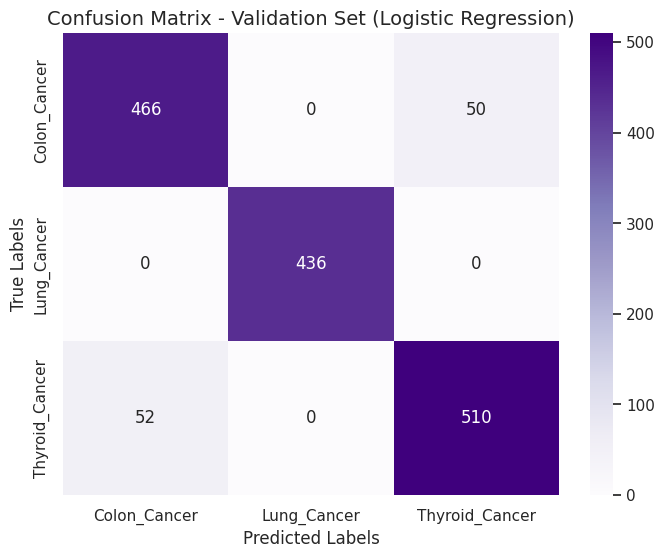

In [23]:

# Step 1: Train Logistic Regression on TRAINING SET
lr_model = LogisticRegression(max_iter=1000, random_state=42)

lr_model.fit(X_train, y_train)

# Step 2: Predict on VALIDATION SET
y_val_pred_lr = lr_model.predict(X_val)

# Step 3: Evaluate on VALIDATION SET
print("Validation Accuracy (Logistic Regression):", round(accuracy_score(y_val, y_val_pred_lr), 4))
print("\nValidation Classification Report (Logistic Regression):\n", classification_report(y_val, y_val_pred_lr))

# Step 4: Confusion Matrix on Validation Set
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, y_val_pred_lr), annot=True, fmt='d', cmap='Purples',
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title("Confusion Matrix - Validation Set (Logistic Regression)", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Logistic Regression outperformed Naive Bayes slightly across the board.

Especially important: Colon_Cancer recall is 1.

Lung_Cancer remained near perfect.

**III. Support Vector Classification with TF-IDF**

Validation Accuracy (SVC): 0.9188

Validation Classification Report (SVC):
                 precision    recall  f1-score   support

  Colon_Cancer       0.88      0.88      0.88       516
   Lung_Cancer       1.00      1.00      1.00       436
Thyroid_Cancer       0.89      0.89      0.89       562

      accuracy                           0.92      1514
     macro avg       0.92      0.92      0.92      1514
  weighted avg       0.92      0.92      0.92      1514



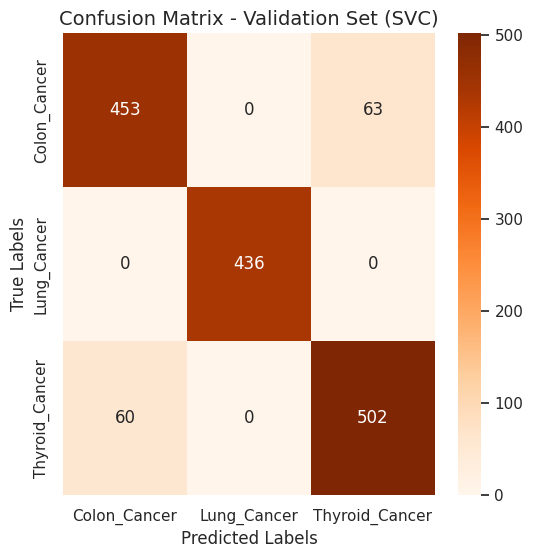

In [24]:
# Step 1: Train Support Vector Classifier
svc_model = SVC(kernel='linear', random_state=44)  # Linear kernel is good for text data

svc_model.fit(X_train, y_train)

# Step 2: Predict on Validation Set
y_val_pred_svc = svc_model.predict(X_val)

# Step 3: Evaluate on Validation Set
print("Validation Accuracy (SVC):", round(accuracy_score(y_val, y_val_pred_svc), 4))
print("\nValidation Classification Report (SVC):\n", classification_report(y_val, y_val_pred_svc))

# Step 4: Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_val, y_val_pred_svc), annot=True, fmt='d', cmap='Oranges',
            xticklabels=svc_model.classes_, yticklabels=svc_model.classes_)
plt.title("Confusion Matrix - Validation Set (SVC)", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


**Out of all the baseline models, we can see that Logistic regression model outperforms Naive Bayes & SVC, although SVC is very close. Choosing Logistic regression model makes sense as it is less time consuming and performs similar to SVC.**

**IV.Ensemble Learning : using multiple ML models (BASE learners) to achieve better performance than one model alone.**

Validation Accuracy (Random Forest): 0.996

Validation Classification Report (Random Forest):
                 precision    recall  f1-score   support

  Colon_Cancer       1.00      0.99      1.00       516
   Lung_Cancer       1.00      1.00      1.00       436
Thyroid_Cancer       0.99      1.00      0.99       562

      accuracy                           1.00      1514
     macro avg       1.00      1.00      1.00      1514
  weighted avg       1.00      1.00      1.00      1514



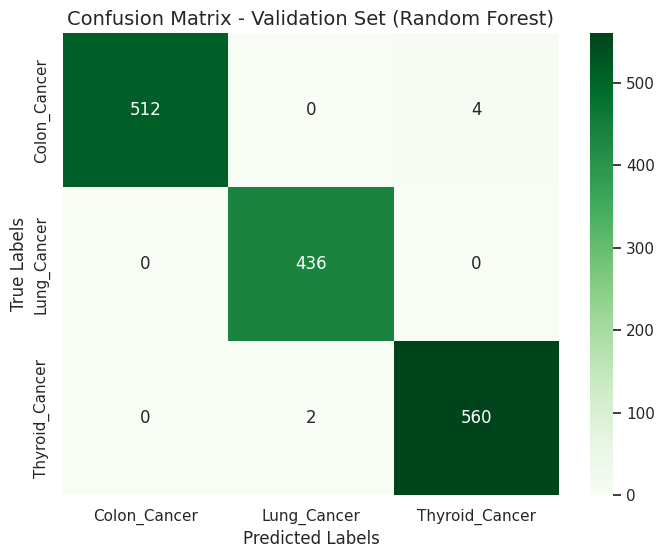

In [25]:
## Random Forest


# Step 1: Train Random Forest
rf_model = RandomForestClassifier(max_depth= 10, n_estimators=50, random_state=44)
rf_model.fit(X_train, y_train)

# Step 2: Predict on Validation Set
y_val_pred_rf = rf_model.predict(X_val)

# Step 3: Evaluate
print("Validation Accuracy (Random Forest):", round(accuracy_score(y_val, y_val_pred_rf), 4))
print("\nValidation Classification Report (Random Forest):\n", classification_report(y_val, y_val_pred_rf))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, y_val_pred_rf), annot=True, fmt='d', cmap='Greens',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix - Validation Set (Random Forest)", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Random Forest accuracy is 1.00, which is very suspicious. The model might be overfitting (needs pruning) or there might be data leakage.

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:14:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy (XGBoost): 1.0

Validation Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       516
           1       1.00      1.00      1.00       436
           2       1.00      1.00      1.00       562

    accuracy                           1.00      1514
   macro avg       1.00      1.00      1.00      1514
weighted avg       1.00      1.00      1.00      1514



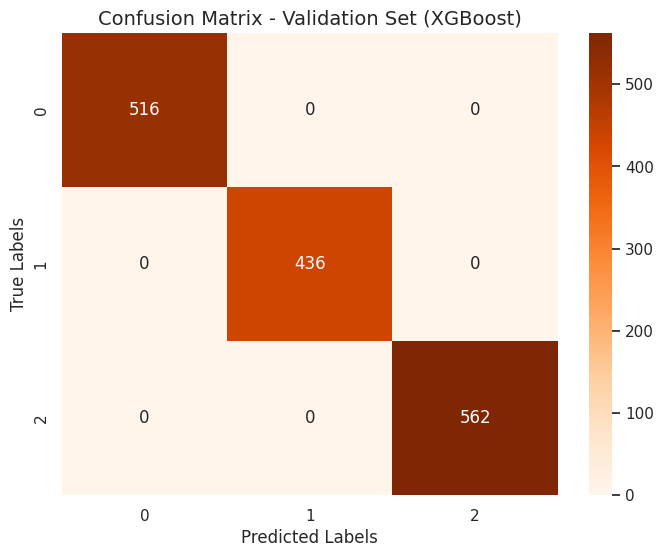

In [26]:
## XGBoost

# Initialize label encoder
le = LabelEncoder()

# Fit and transform on training labels
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)  # Use same encoder (important!)


# Step 1: Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=44)
xgb_model.fit(X_train, y_train_encoded)

# Step 2: Predict on Validation Set
y_val_pred_xgb = xgb_model.predict(X_val)

# Step 3: Evaluate
print("Validation Accuracy (XGBoost):", round(accuracy_score(y_val_encoded, y_val_pred_xgb), 4))
print("\nValidation Classification Report (XGBoost):\n", classification_report(y_val_encoded, y_val_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val_encoded, y_val_pred_xgb), annot=True, fmt='d', cmap='Oranges',
            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.title("Confusion Matrix - Validation Set (XGBoost)", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

LSTM Model

In [27]:
# Prepare data for LSTM
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['cancer_type'])
y = to_categorical(y)
num_classes = y.shape[1]

# first carve out 20% for test
X_temp, X_test, y_temp, y_test = train_test_split(
    df['research_paper'], y,
    test_size=0.2,
    random_state=44,
    stratify=y
)
# then split the 80% into 60% train / 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,        # 0.25 of 80% = 20% total
    random_state=44,
    stratify=y_temp
)


In [28]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)        # ← new
X_test_seq  = tokenizer.texts_to_sequences(X_test)
max_len = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad   = pad_sequences(X_val_seq,   maxlen=max_len)  # ← new
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len)


In [29]:
# Build and compile LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3411, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,435 (3.98 MB)

 Trainable params: 1,042,435 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=512,
    epochs=3
)


Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 9s/step - accuracy: 0.4184 - loss: 1.0780 - val_accuracy: 0.4908 - val_loss: 1.0080
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - accuracy: 0.5620 - loss: 0.9762 - val_accuracy: 0.6242 - val_loss: 0.8276
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.7117 - loss: 0.7669 - val_accuracy: 0.8494 - val_loss: 0.6294


In [31]:
# Evaluate LSTM model
predictions = model.predict(X_test_pad)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 467ms/step
                precision    recall  f1-score   support

  Colon_Cancer       0.89      0.80      0.84       516
   Lung_Cancer       0.87      0.90      0.88       436
Thyroid_Cancer       0.80      0.85      0.83       562

      accuracy                           0.85      1514
     macro avg       0.85      0.85      0.85      1514
  weighted avg       0.85      0.85      0.85      1514



Deep Learning - CNN Model

In [32]:
# Hyper-parameters
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LEN = 100
EMBEDDING_DIM = 128
BATCH_SIZE = 256
EPOCHS = 20
PATIENCE = 3

# Prepare data for CNN
texts = data['research_paper'].tolist()
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(
    sequences,
    maxlen=MAX_SEQUENCE_LEN,
    padding='post',
    truncating='post'
)

In [33]:
le = LabelEncoder()
y_int = le.fit_transform(data['cancer_type'])
num_classes = len(le.classes_)
y = tf.keras.utils.to_categorical(y_int, num_classes=num_classes)

In [34]:
# 1) carve off test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=44,
    stratify=y_int
)
# 2) split remaining into train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,        # 0.25 × 0.80 = 0.20 total
    random_state=44,
    stratify=y_temp
)


In [35]:
# Build CNN model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LEN),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.build(input_shape=(None, MAX_SEQUENCE_LEN))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,732,547 (10.42 MB)

 Trainable params: 2,732,547 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Train CNN model with early stopping
es = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

Epoch 1/20
18/18 - 3s - 154ms/step - accuracy: 0.4941 - loss: 1.0458 - val_accuracy: 0.7431 - val_loss: 0.9608
Epoch 2/20
18/18 - 1s - 57ms/step - accuracy: 0.8232 - loss: 0.7960 - val_accuracy: 0.8778 - val_loss: 0.5648
Epoch 3/20
18/18 - 1s - 55ms/step - accuracy: 0.9293 - loss: 0.3402 - val_accuracy: 0.9498 - val_loss: 0.1336
Epoch 4/20
18/18 - 1s - 57ms/step - accuracy: 0.9641 - loss: 0.1112 - val_accuracy: 0.9683 - val_loss: 0.0671
Epoch 5/20
18/18 - 1s - 56ms/step - accuracy: 0.9652 - loss: 0.0977 - val_accuracy: 0.9663 - val_loss: 0.0788
Epoch 6/20
18/18 - 1s - 55ms/step - accuracy: 0.9692 - loss: 0.0795 - val_accuracy: 0.9630 - val_loss: 0.0627
Epoch 7/20
18/18 - 1s - 56ms/step - accuracy: 0.9692 - loss: 0.0667 - val_accuracy: 0.9663 - val_loss: 0.0522
Epoch 8/20
18/18 - 1s - 55ms/step - accuracy: 0.9738 - loss: 0.0576 - val_accuracy: 0.9683 - val_loss: 0.0487
Epoch 9/20
18/18 - 1s - 55ms/step - accuracy: 0.9725 - loss: 0.0546 - val_accuracy: 0.9676 - val_loss: 0.0533
Epoch 10/

**Out of all the models, CNN has the highest validation accuracy ~97% whereas the LSTM is in the 3rd place with 95.18%, which is very close to CNN's.**


For our final model, we choose **CNN** to run our test set on.

In [37]:
# Evaluate CNN model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest → loss: {test_loss:.4f}, accuracy: {test_acc:.4f}\n")



Test → loss: 0.0383, accuracy: 0.9716



In [38]:
# Detailed per-class metrics
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print("Classification Report:\n",
      classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
print("Confusion Matrix:\n",
      confusion_matrix(y_true_labels, y_pred_labels))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
                 precision    recall  f1-score   support

  Colon_Cancer       0.94      0.98      0.96       516
   Lung_Cancer       1.00      1.00      1.00       436
Thyroid_Cancer       0.98      0.94      0.96       562

      accuracy                           0.97      1514
     macro avg       0.97      0.97      0.97      1514
  weighted avg       0.97      0.97      0.97      1514

Confusion Matrix:
 [[506   0  10]
 [  0 436   0]
 [ 33   0 529]]


We did try compiling a bert pertrained model but were not able to replicate results & got compatilbility issues.